In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 85 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 11.0 MB/s 


In [ ]:
!pip install tensorflow-datasets==4.3

     |████████████████████████████████| 3.9 MB 11.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.4.0
    Uninstalling tensorflow-datasets-4.4.0:
      Successfully uninstalled tensorflow-datasets-4.4.0


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

In [ ]:
import plotly.express as px

# DCN

## Load Data

In [ ]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling movie_lens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movie_lens downloaded and prepared to /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(75_000)
valid = shuffled.skip(75_000).take(10_000)
test = shuffled.skip(85_000).take(15_000)

In [ ]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_valid = valid.batch(4096).cache()
cached_test = test.batch(4096).cache()

## Define Model

In [ ]:
class DCN(tfrs.Model):

  def __init__(self, 
               use_cross_layer, 
               deep_layer_sizes, 
               projection_dim=None, 
               parallel=False):
    super().__init__()

    self.embedding_dimension = 32
    self.parallel = parallel

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    if not self.parallel:
      # Build Cross Network
      if self._cross_layer is not None:
        x = self._cross_layer(x)

      # Build Deep Network
      for deep_layer in self._deep_layers:
        x = deep_layer(x)

      return self._logit_layer(x)
    elif self.parallel and self._cross_layer is not None:
      embed = x
      # Build Cross Network
      cross = self._cross_layer(embed)

      # Build Deep Network
      for deep_layer in self._deep_layers:
        x = deep_layer(x)

      return self._logit_layer(tf.keras.layers.Concatenate()([x, cross]))

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

## Run Model

In [ ]:
def run_models(use_cross_layer, 
               deep_layer_sizes,
               epochs=8,
               learning_rate=0.01, 
               projection_dim=None, 
               num_runs=3, 
               parallel=False):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim,
                parallel=parallel)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    history = model.fit(cached_train, epochs=epochs, validation_data=cached_valid, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv, "history": history}

## Hyperparameter testing func

In [ ]:
def hyperTest(use_cross_layer=True, parallel=True, projection_dim=None):
  """epochs = [5, 10, 15, 20]
  learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
  deep_layer_sizes = [[192, 192], [256, 128], [512, 256, 128]]"""

  epochs = [20]
  learning_rates = [0.01]
  deep_layer_sizes = [[512, 256, 128]]

  best_params = None
  best_metric = 100000
  best_model = None
  params = []
  for epoch in epochs:
    for lr in learning_rates:
      for deep_layer in deep_layer_sizes:
        temp_result = run_models(use_cross_layer, 
                                 deep_layer_sizes=deep_layer, 
                                 parallel=parallel, 
                                 epochs=epoch, 
                                 learning_rate=lr, 
                                 projection_dim=projection_dim)
        param = dict([('epoch', epoch), ('lr', lr), 
                      ('deep_layers', deep_layer), 
                      ('mean', temp_result['mean']), 
                      ('history', temp_result['history'])])
        print(param)
        params.append(param)
        if best_metric > temp_result["mean"]:
          best_metric = temp_result["mean"]
          best_params = param
          best_model = temp_result
  
  return {'best_metric': best_metric, 'best_params': best_params, 'best_model': best_model, 'params': params}

## Hyperparameter Runs

### Parallel Full 

#### Run

In [ ]:
%%timeit
hyper_result = hyperTest()

4/4 [==============================] - 0s 8ms/step - RMSE: 0.9767 - loss: 0.9531 - regularization_loss: 0.0000e+00 - total_loss: 0.9531
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9683327674865723, 'history': <keras.callbacks.History object at 0x7f63b79dac50>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9614 - loss: 0.9292 - regularization_loss: 0.0000e+00 - total_loss: 0.9292
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9912654360135397, 'history': <keras.callbacks.History object at 0x7f63b53c5510>}
4/4 [==============================] - 0s 9ms/step - RMSE: 0.9416 - loss: 0.8852 - regularization_loss: 0.0000e+00 - total_loss: 0.8852
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9682760834693909, 'history': <keras.callbacks.History object at 0x7f63b7bae5d0>}
4/4 [==============================] - 0s 10ms/step - RMSE: 1.0155 - loss: 1.0272 - regularization_loss: 0.0000e+00 - total_loss: 1.0272
{'epoch'

In [ ]:
hyper_result = hyperTest()

4/4 [==============================] - 0s 7ms/step - RMSE: 1.0091 - loss: 1.0197 - regularization_loss: 0.0000e+00 - total_loss: 1.0197
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.012640396753947, 'history': <keras.callbacks.History object at 0x7f6dcb20a610>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9854 - loss: 0.9705 - regularization_loss: 0.0000e+00 - total_loss: 0.9705
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.0038103461265564, 'history': <keras.callbacks.History object at 0x7f6d4f23d650>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9644 - loss: 0.9316 - regularization_loss: 0.0000e+00 - total_loss: 0.9316
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.9648240804672241, 'history': <keras.callbacks.History object at 0x7f6dcbaefbd0>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9409 - loss: 0.8874 - regularization_loss: 0.0000e+00 - total_loss: 0.8874
{'epoch': 5, 'lr': 0

In [ ]:
#pd.DataFrame.from_dict(hyper_result['params'])[['epoch', 'lr',  'mean', 'deep_layers']]
hyper_result['params']

[{'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6dcb20a610>,
  'lr': 0.001,
  'mean': 1.012640396753947},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d4f23d650>,
  'lr': 0.001,
  'mean': 1.0038103461265564},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6dcbaefbd0>,
  'lr': 0.001,
  'mean': 0.9648240804672241},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d4d17cad0>,
  'lr': 0.005,
  'mean': 0.9407645265261332},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d43a6ebd0>,
  'lr': 0.005,
  'mean': 0.9419350822766622},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d49736310>,
  'lr': 0.005,
  'mean': 0.961515208085378},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d41c77d10>,
  'lr': 0

#### Result

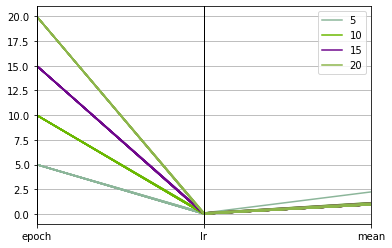

In [ ]:
pd.plotting.parallel_coordinates(pd.DataFrame.from_dict(hyper_result['params'])[['epoch', 'lr',  'mean']], 'epoch', cols=['epoch', 'lr', 'mean'])

In [ ]:
def plotHistory(history):
  rmse = history.history['RMSE']
  val_rmse = history.history['val_RMSE']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(rmse, label='Training RMSE')
  plt.plot(val_rmse, label='Validation RMSE')
  plt.legend(loc='lower right')
  plt.ylabel('RMSE')
  plt.ylim([min(plt.ylim()),2])
  plt.title('Training and Validation RMSE')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Loss')
  plt.ylim([0,2.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

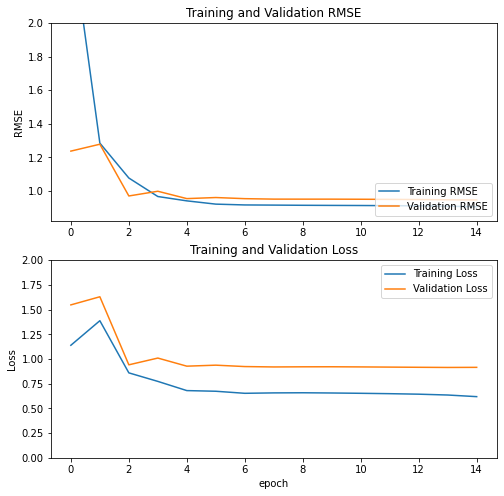

In [ ]:
plotHistory(hyper_result['best_params']['history'])

In [ ]:
df = pd.DataFrame.from_dict(hyper_result['params'])
df['deep_layers'] = [','.join(map(str, l)) for l in df['deep_layers']]

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

### Stacked Full

#### Run

In [ ]:
%%timeit
hyper_result2 = hyperTest(parallel=False)

4/4 [==============================] - 0s 8ms/step - RMSE: 0.9382 - loss: 0.8810 - regularization_loss: 0.0000e+00 - total_loss: 0.8810
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9412225484848022, 'history': <keras.callbacks.History object at 0x7f63b5446b50>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9460 - loss: 0.8928 - regularization_loss: 0.0000e+00 - total_loss: 0.8928
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9454233050346375, 'history': <keras.callbacks.History object at 0x7f63b73999d0>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9631 - loss: 0.9316 - regularization_loss: 0.0000e+00 - total_loss: 0.9316
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9473214149475098, 'history': <keras.callbacks.History object at 0x7f63b8069b10>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9372 - loss: 0.8800 - regularization_loss: 0.0000e+00 - total_loss: 0.8800
{'epoch':

In [ ]:
%%timeit
hyper_result2 = hyperTest(parallel=False)

4/4 [==============================] - 0s 7ms/step - RMSE: 1.0188 - loss: 1.0415 - regularization_loss: 0.0000e+00 - total_loss: 1.0415
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.022661526997884, 'history': <keras.callbacks.History object at 0x7f6c94cda4d0>}
4/4 [==============================] - 0s 8ms/step - RMSE: 1.0169 - loss: 1.0373 - regularization_loss: 0.0000e+00 - total_loss: 1.0373
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.0091301798820496, 'history': <keras.callbacks.History object at 0x7f6d0ac8b210>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9707 - loss: 0.9436 - regularization_loss: 0.0000e+00 - total_loss: 0.9436
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.9708511233329773, 'history': <keras.callbacks.History object at 0x7f6cf7e07050>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9566 - loss: 0.9158 - regularization_loss: 0.0000e+00 - total_loss: 0.9158
{'epoch': 5, 'lr': 0

In [ ]:
hyper_result2

{'best_metric': 0.9292273918787638,
 'best_model': {'history': <keras.callbacks.History at 0x7f6c555a0490>,
  'mean': 0.9292273918787638,
  'model': [<__main__.DCN at 0x7f6c56944ad0>,
  'stdv': 0.0016065959112024689},
 'best_params': {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6c555a0490>,
  'lr': 0.01,
  'mean': 0.9292273918787638},
 'params': [{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c94cda4d0>,
   'lr': 0.001,
   'mean': 1.022661526997884},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6d0ac8b210>,
   'lr': 0.001,
   'mean': 1.0091301798820496},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6cf7e07050>,
   'lr': 0.001,
   'mean': 0.9708511233329773},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ca5509210>,
   'lr': 0.005,
   'mean': 0.955954909324

#### Result

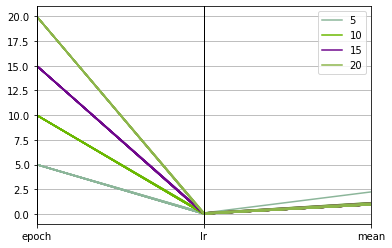

In [ ]:
pd.plotting.parallel_coordinates(pd.DataFrame.from_dict(df)[['epoch', 'lr', 'deep_layers', 'mean']], 'epoch', cols=['epoch', 'lr','mean'])

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result2['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

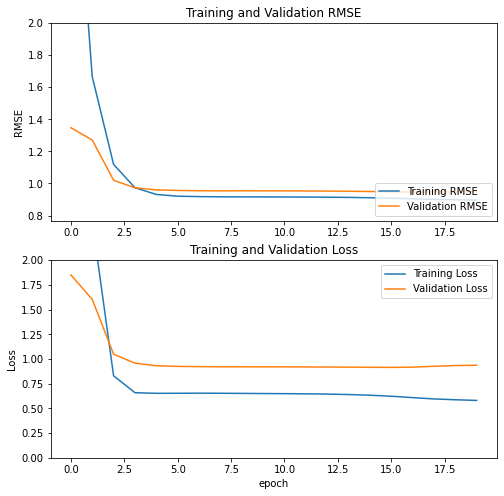

In [ ]:
plotHistory(hyper_result2['best_params']['history'])

### DNN

#### Run

In [ ]:
%%timeit
hyper_result3 = hyperTest(use_cross_layer=False, parallel=False)

4/4 [==============================] - 0s 6ms/step - RMSE: 0.9304 - loss: 0.8693 - regularization_loss: 0.0000e+00 - total_loss: 0.8693
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9412373701731364, 'history': <keras.callbacks.History object at 0x7f63b78a7150>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9400 - loss: 0.8869 - regularization_loss: 0.0000e+00 - total_loss: 0.8869
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9400030771891276, 'history': <keras.callbacks.History object at 0x7f63b7d32490>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9788 - loss: 0.9601 - regularization_loss: 0.0000e+00 - total_loss: 0.9601
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9695799946784973, 'history': <keras.callbacks.History object at 0x7f63b68faad0>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9428 - loss: 0.8916 - regularization_loss: 0.0000e+00 - total_loss: 0.8916
{'epoch':

In [ ]:
hyper_result3 = hyperTest(use_cross_layer=False, parallel=False)

4/4 [==============================] - 0s 7ms/step - RMSE: 1.0052 - loss: 1.0124 - regularization_loss: 0.0000e+00 - total_loss: 1.0124
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.0086823304494221, 'history': <keras.callbacks.History object at 0x7f6c69e5d190>}
4/4 [==============================] - 0s 7ms/step - RMSE: 1.0199 - loss: 1.0430 - regularization_loss: 0.0000e+00 - total_loss: 1.0430
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.0134498278299968, 'history': <keras.callbacks.History object at 0x7f6cc452f090>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9601 - loss: 0.9243 - regularization_loss: 0.0000e+00 - total_loss: 0.9243
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.9648358027140299, 'history': <keras.callbacks.History object at 0x7f6ceb007210>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9398 - loss: 0.8856 - regularization_loss: 0.0000e+00 - total_loss: 0.8856
{'epoch': 5, 'lr': 

In [ ]:
hyper_result3

{'best_metric': 0.9326780239741007,
 'best_model': {'history': <keras.callbacks.History at 0x7f6c1080a390>,
  'mean': 0.9326780239741007,
  'model': [<__main__.DCN at 0x7f6c13523190>,
  'stdv': 0.00094447405166121},
 'best_params': {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6c1080a390>,
  'lr': 0.005,
  'mean': 0.9326780239741007},
 'params': [{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c69e5d190>,
   'lr': 0.001,
   'mean': 1.0086823304494221},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6cc452f090>,
   'lr': 0.001,
   'mean': 1.0134498278299968},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ceb007210>,
   'lr': 0.001,
   'mean': 0.9648358027140299},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c5d4b3050>,
   'lr': 0.005,
   'mean': 0.9454823931058248}

#### Result

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result3['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

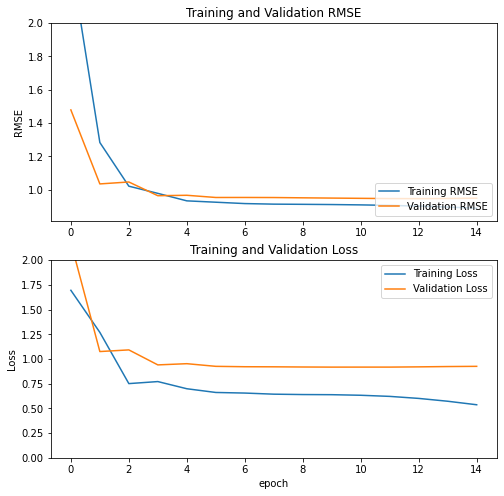

In [ ]:
plotHistory(hyper_result3['best_params']['history'])

### Low Cost Model

#### Run

In [ ]:
%%timeit
hyper_result4 = hyperTest(projection_dim=20)

4/4 [==============================] - 0s 9ms/step - RMSE: 0.9328 - loss: 0.8734 - regularization_loss: 0.0000e+00 - total_loss: 0.8734
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 0.9774001638094584, 'history': <keras.callbacks.History object at 0x7f63b8073050>}
4/4 [==============================] - 0s 7ms/step - RMSE: 1.0086 - loss: 1.0133 - regularization_loss: 0.0000e+00 - total_loss: 1.0133
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 1.0140769084294636, 'history': <keras.callbacks.History object at 0x7f63b52b7290>}
4/4 [==============================] - 0s 8ms/step - RMSE: 1.2776 - loss: 1.6359 - regularization_loss: 0.0000e+00 - total_loss: 1.6359
{'epoch': 20, 'lr': 0.01, 'deep_layers': [512, 256, 128], 'mean': 1.0542256832122803, 'history': <keras.callbacks.History object at 0x7f63b68e4090>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9916 - loss: 0.9842 - regularization_loss: 0.0000e+00 - total_loss: 0.9842
{'epoch':

In [ ]:
hyper_result4 = hyperTest(projection_dim=20)

4/4 [==============================] - 0s 8ms/step - RMSE: 0.9978 - loss: 0.9984 - regularization_loss: 0.0000e+00 - total_loss: 0.9984
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.000368058681488, 'history': <keras.callbacks.History object at 0x7f6c6e8f7450>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9890 - loss: 0.9809 - regularization_loss: 0.0000e+00 - total_loss: 0.9809
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.0008159677187602, 'history': <keras.callbacks.History object at 0x7f6c94620690>}
4/4 [==============================] - 0s 8ms/step - RMSE: 0.9687 - loss: 0.9373 - regularization_loss: 0.0000e+00 - total_loss: 0.9373
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.9692723949750265, 'history': <keras.callbacks.History object at 0x7f6ca6f578d0>}
4/4 [==============================] - 0s 7ms/step - RMSE: 0.9385 - loss: 0.8837 - regularization_loss: 0.0000e+00 - total_loss: 0.8837
{'epoch': 5, 'lr': 0

In [ ]:
hyper_result4

{'best_metric': 0.933172345161438,
 'best_model': {'history': <keras.callbacks.History at 0x7f6bfeb67750>,
  'mean': 0.933172345161438,
  'model': [<__main__.DCN at 0x7f6c39e04210>,
  'stdv': 0.0025958390330976734},
 'best_params': {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6bfeb67750>,
  'lr': 0.01,
  'mean': 0.933172345161438},
 'params': [{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c6e8f7450>,
   'lr': 0.001,
   'mean': 1.000368058681488},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c94620690>,
   'lr': 0.001,
   'mean': 1.0008159677187602},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ca6f578d0>,
   'lr': 0.001,
   'mean': 0.9692723949750265},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c63ba7650>,
   'lr': 0.005,
   'mean': 0.9389805793762207},
 

#### Result

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result4['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

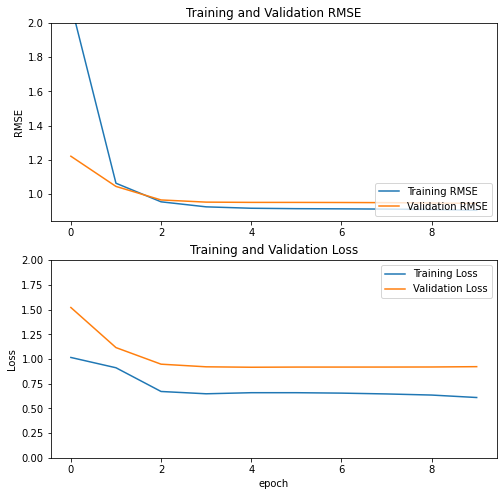

In [ ]:
plotHistory(hyper_result4['best_params']['history'])

In [ ]:
dcn_parallel_result = run_models(use_cross_layer=True,
                                 deep_layer_sizes=[192, 192], 
                                 parallel=True)

4/4 [==============================] - 0s 7ms/step - RMSE: 0.9362 - loss: 0.8796 - regularization_loss: 0.0000e+00 - total_loss: 0.8796


In [ ]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 7ms/step - RMSE: 0.9285 - loss: 0.8633 - regularization_loss: 0.0000e+00 - total_loss: 0.8633


In [ ]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 7ms/step - RMSE: 0.9305 - loss: 0.8662 - regularization_loss: 0.0000e+00 - total_loss: 0.8662


In [ ]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

4/4 [==============================] - 0s 7ms/step - RMSE: 0.9377 - loss: 0.8836 - regularization_loss: 0.0000e+00 - total_loss: 0.8836


In [ ]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9297, stdv: 0.0030
DCN (low-rank) RMSE mean: 0.9313, stdv: 0.0019
DNN            RMSE mean: 0.9365, stdv: 0.0037


## Feature Importance

### Stacked

<Figure size 648x648 with 0 Axes>

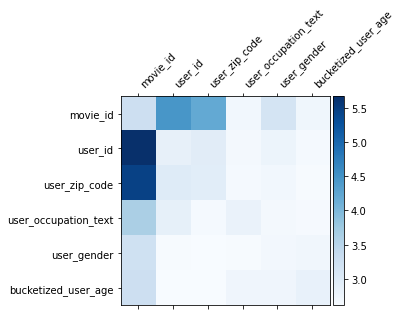

In [ ]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

In [ ]:
mat

<tf.Variable 'dcn_909/cross_720/dense/kernel:0' shape=(192, 192) dtype=float32, numpy=
array([[ 0.02555924,  0.06656504, -0.06064647, ...,  0.0483232 ,
         0.05972375, -0.04169336],
       [-0.17006502, -0.12190767, -0.06624381, ..., -0.10911816,
        -0.21785198, -0.01867141],
       [-0.06786127, -0.03770322, -0.05596093, ...,  0.11616398,
        -0.08607236,  0.02265874],
       ...,
       [-0.13213141, -0.11340215, -0.14013727, ..., -0.04169872,
         0.08722756, -0.06449401],
       [-0.04944763,  0.00612687, -0.01417327, ..., -0.03894474,
         0.03640042, -0.07754523],
       [ 0.02553822, -0.01263651, -0.01356368, ...,  0.07654365,
         0.0183201 , -0.02041914]], dtype=float32)>

In [ ]:
block_norm

array([[3.98966622, 5.84402227, 6.25354528, 3.26727247, 3.24135017,
        3.25784183],
       [6.61509371, 2.84130502, 3.00827861, 2.51885104, 2.48580503,
        2.60290313],
       [6.77003622, 2.88731432, 2.98830128, 2.60656357, 2.42267156,
        2.64431262],
       [3.65239644, 2.53397417, 2.62134814, 2.98460817, 2.50472403,
        2.9003551 ],
       [3.39172482, 2.4372611 , 2.46998692, 2.61840653, 2.93448496,
        2.65331292],
       [4.36157417, 2.58580828, 2.71264482, 2.72584915, 2.64411831,
        3.21205163]])

In [ ]:
dim

32

### Parallel

<Figure size 648x648 with 0 Axes>

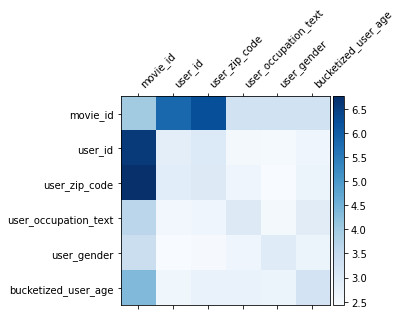

In [ ]:
model = dcn_parallel_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

## Result reconstruction

In [ ]:
import ast
import json
import re

### Raw data

In [ ]:
stacked_full_raw = """[{'deep_layers': [192, 192],
   'epoch': 5,
   
   'lr': 0.001,
   'mean': 1.022661526997884},
  {'deep_layers': [256, 128],
   'epoch': 5,
   
   'lr': 0.001,
   'mean': 1.0091301798820496},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   
   'lr': 0.001,
   'mean': 0.9708511233329773},
  {'deep_layers': [192, 192],
   'epoch': 5,
   
   'lr': 0.005,
   'mean': 0.955954909324646},
  {'deep_layers': [256, 128],
   'epoch': 5,
   
   'lr': 0.005,
   'mean': 0.9477035999298096},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   
   'lr': 0.005,
   'mean': 0.9375423789024353},
  {'deep_layers': [192, 192],
   'epoch': 5,
   
   'lr': 0.01,
   'mean': 0.9385178685188293},
  {'deep_layers': [256, 128],
   'epoch': 5,
   
   'lr': 0.01,
   'mean': 0.942728062470754},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   
   'lr': 0.01,
   'mean': 0.943560520807902},
  {'deep_layers': [192, 192],
   'epoch': 5,
   
   'lr': 0.05,
   'mean': 1.7447983026504517},
  {'deep_layers': [256, 128],
   'epoch': 5,
   
   'lr': 0.05,
   'mean': 1.9063716530799866},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   
   'lr': 0.05,
   'mean': 3.548081318537394},
  {'deep_layers': [192, 192],
   'epoch': 5,
   
   'lr': 0.1,
   'mean': 3.8148950735727944},
  {'deep_layers': [256, 128],
   'epoch': 5,
   
   'lr': 0.1,
   'mean': 3.3685179551442466},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   
   'lr': 0.1,
   'mean': 4.114483992258708},
  {'deep_layers': [192, 192],
   'epoch': 10,
   
   'lr': 0.001,
   'mean': 0.9381877382596334},
  {'deep_layers': [256, 128],
   'epoch': 10,
   
   'lr': 0.001,
   'mean': 0.9384669661521912},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   
   'lr': 0.001,
   'mean': 0.9380054473876953},
  {'deep_layers': [192, 192],
   'epoch': 10,
   
   'lr': 0.005,
   'mean': 0.932645837465922},
  {'deep_layers': [256, 128],
   'epoch': 10,
   
   'lr': 0.005,
   'mean': 0.933021088441213},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   
   'lr': 0.005,
   'mean': 0.9351689020792643},
  {'deep_layers': [192, 192],
   'epoch': 10,
   
   'lr': 0.01,
   'mean': 0.9365100264549255},
  {'deep_layers': [256, 128],
   'epoch': 10,
   
   'lr': 0.01,
   'mean': 0.9435341954231262},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   
   'lr': 0.01,
   'mean': 0.9362574418385824},
  {'deep_layers': [192, 192],
   'epoch': 10,
   
   'lr': 0.05,
   'mean': 1.146790325641632},
  {'deep_layers': [256, 128],
   'epoch': 10,
   
   'lr': 0.05,
   'mean': 1.1310299237569172},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   
   'lr': 0.05,
   'mean': 2.4982704520225525},
  {'deep_layers': [192, 192],
   'epoch': 10,
   
   'lr': 0.1,
   'mean': 2.881645997365316},
  {'deep_layers': [256, 128],
   'epoch': 10,
   
   'lr': 0.1,
   'mean': 2.6399053732554116},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   
   'lr': 0.1,
   'mean': 2.0967887242635093},
  {'deep_layers': [192, 192],
   'epoch': 15,
   
   'lr': 0.001,
   'mean': 0.9381240208943685},
  {'deep_layers': [256, 128],
   'epoch': 15,
   
   'lr': 0.001,
   'mean': 0.9378200570742289},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   
   'lr': 0.001,
   'mean': 0.9360669056574503},
  {'deep_layers': [192, 192],
   'epoch': 15,
   
   'lr': 0.005,
   'mean': 0.9377874533335367},
  {'deep_layers': [256, 128],
   'epoch': 15,
   
   'lr': 0.005,
   'mean': 0.9366146723429362},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   
   'lr': 0.005,
   'mean': 0.9412827889124552},
  {'deep_layers': [192, 192],
   'epoch': 15,
   
   'lr': 0.01,
   'mean': 0.9729291598002116},
  {'deep_layers': [256, 128],
   'epoch': 15,
   
   'lr': 0.01,
   'mean': 0.9679115613301595},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   
   'lr': 0.01,
   'mean': 0.937964916229248},
  {'deep_layers': [192, 192],
   'epoch': 15,
   
   'lr': 0.05,
   'mean': 1.0117254257202148},
  {'deep_layers': [256, 128],
   'epoch': 15,
   
   'lr': 0.05,
   'mean': 1.0693148374557495},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   
   'lr': 0.05,
   'mean': 2.588118553161621},
  {'deep_layers': [192, 192],
   'epoch': 15,
   
   'lr': 0.1,
   'mean': 1.7668469349543254},
  {'deep_layers': [256, 128],
   'epoch': 15,
   
   'lr': 0.1,
   'mean': 2.442292253176371},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   
   'lr': 0.1,
   'mean': 3.882239818572998},
  {'deep_layers': [192, 192],
   'epoch': 20,
   
   'lr': 0.001,
   'mean': 0.9374140501022339},
  {'deep_layers': [256, 128],
   'epoch': 20,
   
   'lr': 0.001,
   'mean': 0.9376093745231628},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   
   'lr': 0.001,
   'mean': 0.9336069424947103},
  {'deep_layers': [192, 192],
   'epoch': 20,
   
   'lr': 0.005,
   'mean': 0.9634037812550863},
  {'deep_layers': [256, 128],
   'epoch': 20,
   
   'lr': 0.005,
   'mean': 0.9587644537289938},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   
   'lr': 0.005,
   'mean': 1.0010449687639873},
  {'deep_layers': [192, 192],
   'epoch': 20,
   
   'lr': 0.01,
   'mean': 1.0280931790669758},
  {'deep_layers': [256, 128],
   'epoch': 20,
   
   'lr': 0.01,
   'mean': 0.9984155893325806},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   
   'lr': 0.01,
   'mean': 0.9292273918787638},
  {'deep_layers': [192, 192],
   'epoch': 20,
   
   'lr': 0.05,
   'mean': 1.122428337732951},
  {'deep_layers': [256, 128],
   'epoch': 20,
   
   'lr': 0.05,
   'mean': 1.0060163140296936},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   
   'lr': 0.05,
   'mean': 2.029179334640503},
  {'deep_layers': [192, 192],
   'epoch': 20,
   
   'lr': 0.1,
   'mean': 1.3230196634928386},
  {'deep_layers': [256, 128],
   'epoch': 20,
   
   'lr': 0.1,
   'mean': 1.5245104630788167},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'lr': 0.1,
   'mean': 3.735294500986735}]"""

In [ ]:
parallel_full_raw = """[{'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6dcb20a610>,
  'lr': 0.001,
  'mean': 1.012640396753947},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d4f23d650>,
  'lr': 0.001,
  'mean': 1.0038103461265564},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6dcbaefbd0>,
  'lr': 0.001,
  'mean': 0.9648240804672241},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d4d17cad0>,
  'lr': 0.005,
  'mean': 0.9407645265261332},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d43a6ebd0>,
  'lr': 0.005,
  'mean': 0.9419350822766622},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d49736310>,
  'lr': 0.005,
  'mean': 0.961515208085378},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d41c77d10>,
  'lr': 0.01,
  'mean': 0.9507565299669901},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d3cc2fe10>,
  'lr': 0.01,
  'mean': 0.9463439583778381},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d49afb610>,
  'lr': 0.01,
  'mean': 0.961996873219808},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d3c6bc890>,
  'lr': 0.05,
  'mean': 1.0199837287267048},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d38e7e490>,
  'lr': 0.05,
  'mean': 0.9801702896753947},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d43721a10>,
  'lr': 0.05,
  'mean': 1.1063355207443237},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d43581550>,
  'lr': 0.1,
  'mean': 1.139048417409261},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d49604050>,
  'lr': 0.1,
  'mean': 1.042356292406718},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7f6d435a0c50>,
  'lr': 0.1,
  'mean': 2.2311861912409463},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d4199e890>,
  'lr': 0.001,
  'mean': 0.9386534094810486},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d32322050>,
  'lr': 0.001,
  'mean': 0.9389771024386088},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d2fb03e90>,
  'lr': 0.001,
  'mean': 0.9383209347724915},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d3c8a9d50>,
  'lr': 0.005,
  'mean': 0.9379720091819763},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d498fea10>,
  'lr': 0.005,
  'mean': 0.938210149606069},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d3c79dc10>,
  'lr': 0.005,
  'mean': 0.9372483094533285},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d29d5d710>,
  'lr': 0.01,
  'mean': 0.9337382515271505},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d32079890>,
  'lr': 0.01,
  'mean': 0.9328128496805826},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d31f2d550>,
  'lr': 0.01,
  'mean': 0.9442931016286215},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d264af190>,
  'lr': 0.05,
  'mean': 0.9399426579475403},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d22c60190>,
  'lr': 0.05,
  'mean': 0.943556567033132},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d4d540090>,
  'lr': 0.05,
  'mean': 0.9557667970657349},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d32503090>,
  'lr': 0.1,
  'mean': 0.9535648624102274},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d4d276110>,
  'lr': 0.1,
  'mean': 0.9544710318247477},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7f6d1e165910>,
  'lr': 0.1,
  'mean': 1.1381231546401978},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d45a8cb50>,
  'lr': 0.001,
  'mean': 0.9380343556404114},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d22a101d0>,
  'lr': 0.001,
  'mean': 0.938245435555776},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d38fd4790>,
  'lr': 0.001,
  'mean': 0.9380996425946554},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d457332d0>,
  'lr': 0.005,
  'mean': 0.9322387377421061},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d185fcd90>,
  'lr': 0.005,
  'mean': 0.9308719635009766},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d14d66190>,
  'lr': 0.005,
  'mean': 0.9337810675303141},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d497cf750>,
  'lr': 0.01,
  'mean': 0.9534931580225626},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d357d4e10>,
  'lr': 0.01,
  'mean': 0.9511052966117859},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d1fe78110>,
  'lr': 0.01,
  'mean': 0.9728760123252869},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d1ddbfa10>,
  'lr': 0.05,
  'mean': 0.9372614026069641},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d11d65cd0>,
  'lr': 0.05,
  'mean': 0.941581130027771},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d14d5af10>,
  'lr': 0.05,
  'mean': 0.9422298471132914},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d2fd47310>,
  'lr': 0.1,
  'mean': 0.951613187789917},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d11a4b750>,
  'lr': 0.1,
  'mean': 0.9483135342597961},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d0b228150>,
  'lr': 0.1,
  'mean': 1.1043741305669148},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d0797c250>,
  'lr': 0.001,
  'mean': 0.9384906888008118},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d0512b510>,
  'lr': 0.001,
  'mean': 0.9387045105298361},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d12090a90>,
  'lr': 0.001,
  'mean': 0.9378902117411295},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d14f08bd0>,
  'lr': 0.005,
  'mean': 0.9382935563723246},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d1ddff310>,
  'lr': 0.005,
  'mean': 0.9360169569651285},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d11723890>,
  'lr': 0.005,
  'mean': 0.941397229830424},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d064e2c10>,
  'lr': 0.01,
  'mean': 0.9674788117408752},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6cfe094090>,
  'lr': 0.01,
  'mean': 0.9605332414309183},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d2fb2f7d0>,
  'lr': 0.01,
  'mean': 0.9643777012825012},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6dcb4860d0>,
  'lr': 0.05,
  'mean': 0.9481306473414103},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d11557c90>,
  'lr': 0.05,
  'mean': 0.9477185209592184},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d1dd29ed0>,
  'lr': 0.05,
  'mean': 0.9414390325546265},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6cfde0b690>,
  'lr': 0.1,
  'mean': 0.9450064102808634},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6cfc5c28d0>,
  'lr': 0.1,
  'mean': 1.0091410676638286},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7f6d1e9e7ed0>,
  'lr': 0.1,
  'mean': 1.0904242197672527}]"""

In [ ]:
dnn_raw = """[{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c69e5d190>,
   'lr': 0.001,
   'mean': 1.0086823304494221},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6cc452f090>,
   'lr': 0.001,
   'mean': 1.0134498278299968},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ceb007210>,
   'lr': 0.001,
   'mean': 0.9648358027140299},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c5d4b3050>,
   'lr': 0.005,
   'mean': 0.9454823931058248},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ca1085290>,
   'lr': 0.005,
   'mean': 0.9562290708223978},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c89800dd0>,
   'lr': 0.005,
   'mean': 0.9578292568524679},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c6cbca5d0>,
   'lr': 0.01,
   'mean': 0.9474369883537292},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c4ca881d0>,
   'lr': 0.01,
   'mean': 0.9451707005500793},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c49228f90>,
   'lr': 0.01,
   'mean': 0.9485117594401041},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c435c7190>,
   'lr': 0.05,
   'mean': 1.9915566643079121},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c3d5b6f50>,
   'lr': 0.05,
   'mean': 2.1326016187667847},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c39dbe0d0>,
   'lr': 0.05,
   'mean': 3.540419816970825},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c3660c790>,
   'lr': 0.1,
   'mean': 2.831620534261068},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c32dd5050>,
   'lr': 0.1,
   'mean': 2.4920361836751304},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c2f6428d0>,
   'lr': 0.1,
   'mean': 3.287068804105123},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c2be15450>,
   'lr': 0.001,
   'mean': 0.9385416110356649},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c25693890>,
   'lr': 0.001,
   'mean': 0.9383688767751058},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c9193b310>,
   'lr': 0.001,
   'mean': 0.9378782113393148},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c9902ce10>,
   'lr': 0.005,
   'mean': 0.9356855551401774},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c6e9604d0>,
   'lr': 0.005,
   'mean': 0.9354904492696127},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c784eaa10>,
   'lr': 0.005,
   'mean': 0.9368235071500143},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c791161d0>,
   'lr': 0.01,
   'mean': 0.9337655504544576},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c4fe65b10>,
   'lr': 0.01,
   'mean': 0.9361753066380819},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c6cc0e910>,
   'lr': 0.01,
   'mean': 0.9393118222554525},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c692a1450>,
   'lr': 0.05,
   'mean': 1.5625954071680705},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c32eb58d0>,
   'lr': 0.05,
   'mean': 1.3220557769139607},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c4565a190>,
   'lr': 0.05,
   'mean': 1.7852342128753662},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c4ff10690>,
   'lr': 0.1,
   'mean': 1.0971089601516724},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c36a450d0>,
   'lr': 0.1,
   'mean': 1.701899806658427},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c20f92b50>,
   'lr': 0.1,
   'mean': 2.106919844945272},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6ca8b0e1d0>,
   'lr': 0.001,
   'mean': 0.9379855593045553},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c1af69b10>,
   'lr': 0.001,
   'mean': 0.9381271600723267},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c17772810>,
   'lr': 0.001,
   'mean': 0.9368854959805807},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c13fc9710>,
   'lr': 0.005,
   'mean': 0.9341029723485311},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c1080a390>,
   'lr': 0.005,
   'mean': 0.9326780239741007},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c0cff8b90>,
   'lr': 0.005,
   'mean': 0.9591231346130371},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c1a524f50>,
   'lr': 0.01,
   'mean': 0.9440946777661642},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c56bdbe50>,
   'lr': 0.01,
   'mean': 0.9735954602559408},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6cc7d3f410>,
   'lr': 0.01,
   'mean': 0.9357362190882365},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c1a24ff10>,
   'lr': 0.05,
   'mean': 1.028674801190694},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6cc0c05950>,
   'lr': 0.05,
   'mean': 1.1511144240697224},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c9cea9090>,
   'lr': 0.05,
   'mean': 2.5101701418558755},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c63b467d0>,
   'lr': 0.1,
   'mean': 1.3469524780909221},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c169e8ad0>,
   'lr': 0.1,
   'mean': 1.1081910133361816},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c59b25050>,
   'lr': 0.1,
   'mean': 3.6376211643218994},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c218c0550>,
   'lr': 0.001,
   'mean': 0.9380554954210917},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c1b925750>,
   'lr': 0.001,
   'mean': 0.9384955366452535},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6ca8d28090>,
   'lr': 0.001,
   'mean': 0.9348364273707072},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c20c29390>,
   'lr': 0.005,
   'mean': 0.9554731845855713},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c0956f050>,
   'lr': 0.005,
   'mean': 0.9441508253415426},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c05d61050>,
   'lr': 0.005,
   'mean': 0.9887294967969259},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c02535b10>,
   'lr': 0.01,
   'mean': 0.9943149288495382},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bfed79b50>,
   'lr': 0.01,
   'mean': 1.0083357493082683},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bfb571350>,
   'lr': 0.01,
   'mean': 0.9393498698870341},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf7dc7890>,
   'lr': 0.05,
   'mean': 1.1447618007659912},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf460d290>,
   'lr': 0.05,
   'mean': 0.942866325378418},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf0e03650>,
   'lr': 0.05,
   'mean': 1.9301613171895344},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bed5e1790>,
   'lr': 0.1,
   'mean': 1.1271473169326782},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bfe7e9850>,
   'lr': 0.1,
   'mean': 1.1691588163375854},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c3d848a10>,
   'lr': 0.1,
   'mean': 2.0074888865152993}]"""

In [ ]:
stacked_low_raw = """[{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c6e8f7450>,
   'lr': 0.001,
   'mean': 1.000368058681488},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c94620690>,
   'lr': 0.001,
   'mean': 1.0008159677187602},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ca6f578d0>,
   'lr': 0.001,
   'mean': 0.9692723949750265},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c63ba7650>,
   'lr': 0.005,
   'mean': 0.9389805793762207},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c3dad90d0>,
   'lr': 0.005,
   'mean': 0.9399542808532715},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c0fd0a1d0>,
   'lr': 0.005,
   'mean': 0.9507050712903341},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf7aa89d0>,
   'lr': 0.01,
   'mean': 0.9489022095998129},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf78b1a10>,
   'lr': 0.01,
   'mean': 0.944469153881073},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c096cc650>,
   'lr': 0.01,
   'mean': 0.9467695554097494},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c0908f050>,
   'lr': 0.05,
   'mean': 0.967252254486084},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf79f8810>,
   'lr': 0.05,
   'mean': 0.9676798184712728},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c020b6090>,
   'lr': 0.05,
   'mean': 1.0815852483113606},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf6879550>,
   'lr': 0.1,
   'mean': 1.5494410196940105},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6be922e850>,
   'lr': 0.1,
   'mean': 1.1817898750305176},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6be715f990>,
   'lr': 0.1,
   'mean': 2.379037102063497},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be2ff7110>,
   'lr': 0.001,
   'mean': 0.9389605522155762},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bdc7b0350>,
   'lr': 0.001,
   'mean': 0.939000646273295},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bd8ede050>,
   'lr': 0.001,
   'mean': 0.9384143153826395},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be114c250>,
   'lr': 0.005,
   'mean': 0.9371030926704407},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bd1e32310>,
   'lr': 0.005,
   'mean': 0.9386645158131918},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c18055750>,
   'lr': 0.005,
   'mean': 0.9375331799189249},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6cc731dc50>,
   'lr': 0.01,
   'mean': 0.9346014857292175},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bfeb67750>,
   'lr': 0.01,
   'mean': 0.933172345161438},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c5c9d3090>,
   'lr': 0.01,
   'mean': 0.940509299437205},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c6cab4150>,
   'lr': 0.05,
   'mean': 0.9477801521619161},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c20aa15d0>,
   'lr': 0.05,
   'mean': 0.9418696959813436},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c332e8a50>,
   'lr': 0.05,
   'mean': 0.9716687401135763},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be73c1150>,
   'lr': 0.1,
   'mean': 0.9527191519737244},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be7725090>,
   'lr': 0.1,
   'mean': 0.9739111264546713},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bf7e779d0>,
   'lr': 0.1,
   'mean': 1.1295245091120403},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6be963e4d0>,
   'lr': 0.001,
   'mean': 0.938054084777832},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bdd3e8090>,
   'lr': 0.001,
   'mean': 0.9380642970403036},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bed1a6a50>,
   'lr': 0.001,
   'mean': 0.9378294746081034},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c9a13ac90>,
   'lr': 0.005,
   'mean': 0.9340311090151469},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bdb300290>,
   'lr': 0.005,
   'mean': 0.934217115243276},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bce2576d0>,
   'lr': 0.005,
   'mean': 0.9417093793551127},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bca9e9190>,
   'lr': 0.01,
   'mean': 0.9471367001533508},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bc7167090>,
   'lr': 0.01,
   'mean': 0.9355885982513428},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bc3899110>,
   'lr': 0.01,
   'mean': 0.9622859756151835},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bbffef1d0>,
   'lr': 0.05,
   'mean': 0.9431696534156799},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bbe72f790>,
   'lr': 0.05,
   'mean': 0.9473694562911987},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bb9663110>,
   'lr': 0.05,
   'mean': 0.9405649900436401},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bbe80d5d0>,
   'lr': 0.1,
   'mean': 0.9493876695632935},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c4370ef50>,
   'lr': 0.1,
   'mean': 0.9538472096125284},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6ca8678a10>,
   'lr': 0.1,
   'mean': 1.1180118719736736},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c49202910>,
   'lr': 0.001,
   'mean': 0.9385871887207031},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c6760e910>,
   'lr': 0.001,
   'mean': 0.9385058085123698},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf7869790>,
   'lr': 0.001,
   'mean': 0.9369035760561625},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c022bff10>,
   'lr': 0.005,
   'mean': 0.9400285879770914},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf0818f50>,
   'lr': 0.005,
   'mean': 0.9381002982457479},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bc9f17590>,
   'lr': 0.005,
   'mean': 0.9504168430964152},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bed7032d0>,
   'lr': 0.01,
   'mean': 0.9682369828224182},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c1b8672d0>,
   'lr': 0.01,
   'mean': 0.9452779293060303},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bfeb1b250>,
   'lr': 0.01,
   'mean': 0.9603259960810343},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bdb51a450>,
   'lr': 0.05,
   'mean': 0.9489754438400269},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6be16445d0>,
   'lr': 0.05,
   'mean': 0.9694866339365641},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bdaf96a50>,
   'lr': 0.05,
   'mean': 0.9421877463658651},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bb6cac310>,
   'lr': 0.1,
   'mean': 0.9470345179239908},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bb0aaa290>,
   'lr': 0.1,
   'mean': 0.9497267603874207},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bae9db590>,
   'lr': 0.1,
   'mean': 1.0898589293162029}]"""

### Stacked Full

In [ ]:
layer_mapping = {}
for i, layer in enumerate(set(stacked_full_df['deep_layers'])):
  layer_mapping[layer] = i

In [ ]:
layer_mapping

{'192,192': 1, '256,128': 0, '512,256,128': 2}

In [ ]:
stacked_full_list = ast.literal_eval(stacked_full_raw)
stacked_full_df = pd.DataFrame(stacked_full_list)
stacked_full_df['deep_layers'] = [','.join(map(str, l)) for l in stacked_full_df['deep_layers']]
stacked_full_df['mapped_layer_type'] = [layer_mapping[layer] for layer in stacked_full_df['deep_layers']]

In [ ]:
fig = px.parallel_categories(stacked_full_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                             dimensions=['epoch', 'lr', 'mapped_layer_type'],
                color='mean',  color_continuous_scale=px.colors.sequential.Inferno,
                labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'})
fig.show()

In [ ]:
px.parallel_coordinates(stacked_full_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

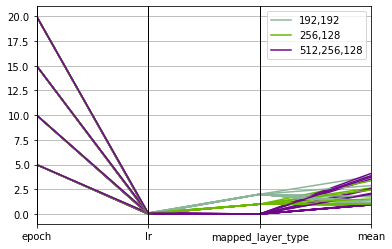

In [ ]:
pd.plotting.parallel_coordinates(stacked_full_df[['deep_layers', 'epoch', 'lr', 'mapped_layer_type', 'mean']], 
                                 'deep_layers', 
                                 cols=['epoch', 'lr', 'mapped_layer_type', 'mean'])

### Parallel Full

In [ ]:
parallel_full_list = ast.literal_eval(re.sub("\'history\'\: \<(.*?)\>,", '', parallel_full_raw))
parallel_full_df = pd.DataFrame(parallel_full_list)
parallel_full_df['deep_layers'] = [','.join(map(str, l)) for l in parallel_full_df['deep_layers']]
parallel_full_df['mapped_layer_type'] = [layer_mapping[layer] for layer in parallel_full_df['deep_layers']]

In [ ]:
px.parallel_coordinates(parallel_full_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

### DNN

In [ ]:
dnn_list = ast.literal_eval(re.sub("\'history\'\: \<(.*?)\>,", '', dnn_raw))
dnn_df = pd.DataFrame(dnn_list)
dnn_df['deep_layers'] = [','.join(map(str, l)) for l in dnn_df['deep_layers']]
dnn_df['mapped_layer_type'] = [layer_mapping[layer] for layer in dnn_df['deep_layers']]

In [ ]:
px.parallel_coordinates(dnn_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

### Stacked Low Cost

In [ ]:
stacked_low_list = ast.literal_eval(re.sub("\'history\'\: \<(.*?)\>,", '', stacked_low_raw))
stacked_low_df = pd.DataFrame(stacked_low_list)
stacked_low_df['deep_layers'] = [','.join(map(str, l)) for l in stacked_low_df['deep_layers']]
stacked_low_df['mapped_layer_type'] = [layer_mapping[layer] for layer in stacked_low_df['deep_layers']]

In [ ]:
px.parallel_coordinates(stacked_low_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

In [ ]:
stacked_time = 27.2
parallel_time = 27.9
dnn_time = 22.9
stacked_low_time = 26.4

# DCN v2

In [ ]:
stacked {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'lr': 0.01,
   'mean': 0.9292273918787638},

In [ ]:
parallel {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7f6d185fcd90>,
  'lr': 0.005,
  'mean': 0.9308719635009766},

In [ ]:
dnn {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c1080a390>,
   'lr': 0.005,
   'mean': 0.9326780239741007},

In [ ]:
stacked low cost {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bfeb67750>,
   'lr': 0.01,
   'mean': 0.933172345161438},